In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

# Purpose

The purpose of this notebook is to prototype code for classifying ripples as towards vs. away the animal's current position

In [141]:
import numpy as np
import pandas as pd
import xarray as xr

from src.parameters import MULTITAPER_PARAMETERS, SAMPLING_FREQUENCY, ANIMALS
from src.analysis import detect_epoch_ripples, decode_ripple_clusterless

In [3]:
epoch_key = ('HPa', 6, 2)

In [4]:
ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, sampling_frequency=SAMPLING_FREQUENCY)

In [8]:
from dask import local, compute, delayed

from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)
from src.ripple_decoding import (combined_likelihood,
                              estimate_marked_encoding_model,
                              estimate_sorted_spike_encoding_model,
                              estimate_state_transition, get_bin_centers,
                              predict_state, set_initial_conditions)
from src.analysis import (_get_place, _get_training_marks,
                          estimate_marked_encoding_model, estimate_state_transition,
                          set_initial_conditions, _get_ripple_marks, _get_place_at_spike)

def decode_ripple_clusterless2(epoch_key, animals, ripple_times,
                              sampling_frequency=1500,
                              n_place_bins=61,
                              place_std_deviation=None,
                              mark_std_deviation=20,
                              scheduler=local.get_sync,
                              scheduler_kwargs={}):
    tetrode_info = make_tetrode_dataframe(animals)[epoch_key]
    mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                      'channel_4_max']
    hippocampal_tetrodes = tetrode_info.loc[
        tetrode_info.area.isin(['CA1', 'iCA1']) &
        ~tetrode_info.descrip.str.endswith('Ref').fillna(False), :]

    position_info = (get_interpolated_position_dataframe(
        epoch_key, animals))

    marks = [(get_mark_indicator_dataframe(tetrode_key, animals)
              .loc[:, mark_variables])
             for tetrode_key in hippocampal_tetrodes.index]
    marks = [tetrode_marks for tetrode_marks in marks
             if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
                 .shape[0]) != 0]

    train_position_info = position_info.query('speed > 4')

    place = _get_place(train_position_info)
    place_at_spike = [_get_place_at_spike(tetrode_marks,
                                          train_position_info)
                      for tetrode_marks in marks]
    training_marks = [_get_training_marks(tetrode_marks,
                                          train_position_info,
                                          mark_variables)
                      for tetrode_marks in marks]

    place_bin_edges = np.linspace(
        np.floor(position_info.linear_distance.min()),
        np.ceil(position_info.linear_distance.max()),
        n_place_bins + 1)
    place_bin_centers = get_bin_centers(place_bin_edges)

    if place_std_deviation is None:
        place_std_deviation = place_bin_edges[1] - place_bin_edges[0]
    combined_likelihood_kwargs = estimate_marked_encoding_model(
        place_bin_centers, place, place_at_spike, training_marks,
        place_std_deviation=place_std_deviation,
        mark_std_deviation=mark_std_deviation)

    state_transition = estimate_state_transition(
        train_position_info, place_bin_edges)

    state_names = ['outbound_forward', 'outbound_reverse',
                   'inbound_forward', 'inbound_reverse']
    n_states = len(state_names)
    initial_conditions = set_initial_conditions(
        place_bin_edges, place_bin_centers, n_states)

    decoder_kwargs = dict(
        initial_conditions=initial_conditions,
        state_transition=state_transition,
        likelihood_function=combined_likelihood,
        likelihood_kwargs=combined_likelihood_kwargs
    )

    test_marks = _get_ripple_marks(
        marks, ripple_times, sampling_frequency)

    posterior_density = [
        delayed(predict_state, pure=True)(ripple_marks, **decoder_kwargs)
        for ripple_marks in test_marks]
    posterior_density = compute(
        *posterior_density, get=scheduler, **scheduler_kwargs)
    test_spikes = [np.mean(~np.isnan(marks), axis=2)
                   for marks in test_marks]
    
    return (posterior_density, test_spikes, ripple_times,
            state_names, position_info, epoch_key)

In [9]:
(posterior_density, test_spikes, ripple_times,
 state_names, position_info, epoch_key) = decode_ripple_clusterless2(epoch_key, ANIMALS, ripple_times[:5])

In [10]:
from src.analysis import (
    _compute_decision_state_probability, _compute_max_state,
    _num_unique_neurons_spiking, _num_total_spikes, _ripple_session_time)

session_time = position_info.index

n_states = len(state_names)
n_ripples = len(ripple_times)
decision_state_probability = [
    _compute_decision_state_probability(density, n_states)
    for density in posterior_density]
index = pd.MultiIndex.from_tuples(
    [(*epoch_key, ripple+1) for ripple in range(n_ripples)],
    names=['animal', 'day', 'epoch', 'ripple_number'])
ripple_info = pd.DataFrame(
    [_compute_max_state(probability, state_names)
     for probability in decision_state_probability],
    columns=['ripple_trajectory', 'ripple_direction',
             'ripple_state_probability'],
    index=index)
ripple_info['ripple_start_time'] = np.asarray(ripple_times)[:, 0]
ripple_info['ripple_end_time'] = np.asarray(ripple_times)[:, 1]
ripple_info['number_of_unique_neurons_spiking'] = [
    _num_unique_neurons_spiking(spikes) for spikes in test_spikes]
ripple_info['number_of_spikes'] = [_num_total_spikes(spikes)
                                   for spikes in test_spikes]
ripple_info['session_time'] = _ripple_session_time(
    ripple_times, session_time)
ripple_info['is_spike'] = ((ripple_info.number_of_spikes > 0)
                           .map({True: 'isSpike', False: 'noSpike'}))
ripple_info = pd.concat(
    [ripple_info, position_info.loc[ripple_info.ripple_start_time]
     .set_index(ripple_info.index)], axis=1)

In [11]:
ripple_info

ripple_trajectory ripple_direction  \
animal day epoch ripple_number                                      
HPa    6   2     1                      outbound          reverse   
                 2                      outbound          reverse   
                 3                      outbound          reverse   
                 4                       inbound          reverse   
                 5                      outbound          reverse   

                                ripple_state_probability  ripple_start_time  \
animal day epoch ripple_number                                                
HPa    6   2     1                              0.873182        4137.813333   
                 2                              0.992965        4139.667333   
                 3                              0.988171        4142.945333   
                 4                              0.414060        4168.426667   
                 5                              0.809156        4197.592667   

                                ripple_end_time  \
animal day epoch ripple_number                    
HPa    6   2     1                  4137.874667   
                 2                  4139.732667   
                 3                  4142.986667   
                 4                  4168.463333   
                 5                  4197.628000   

                                number_of_unique_neurons_spiking  \
animal day epoch ripple_number                                     
HPa    6   2     1                                            11   
                 2                                             9   
                 3                                             9   
                 4                                             6   
                 5                                             8   

                                number_of_spikes session_time is_spike  \
animal day epoch ripple_number                                           
HPa    6   2     1                            46        early  isSpike   
                 2                            39        early  isSpike   
                 3                            46        early  isSpike   
                 4                            15        early  isSpike   
                 5                            30        early  isSpike   

                                trajectory_category_ind trajectory_direction  \
animal day epoch ripple_number                                                 
HPa    6   2     1                                  1.0             Outbound   
                 2                                  1.0             Outbound   
                 3                                  1.0             Outbound   
                 4                                  3.0             Outbound   
                 5                                  1.0             Outbound   

                               trajectory_turn  trial_number  linear_distance  \
animal day epoch ripple_number                                                  
HPa    6   2     1                        Left           8.0       186.983089   
                 2                        Left           8.0       186.884549   
                 3                        Left           8.0       183.265667   
                 4                        Left          29.0       184.460973   
                 5                        Left          38.0       185.130526   

                                x_position  y_position  head_direction  \
animal day epoch ripple_number                                           
HPa    6   2     1               63.680232   99.412275        0.404806   
                 2               63.759031   99.231902       -0.100622   
                 3               61.563055   96.030375       -0.505139   
                 4              125.013324  100.932914        1.314661   
                 5               61.239997   97.757959       -0.07

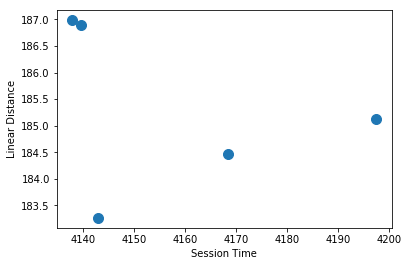

In [13]:
import matplotlib.pyplot as plt
plt.plot(
    ripple_info.ripple_start_time,
    ripple_info.linear_distance,linestyle='None', marker='.', markersize=20);
plt.xlabel('Session Time')
plt.ylabel('Linear Distance')

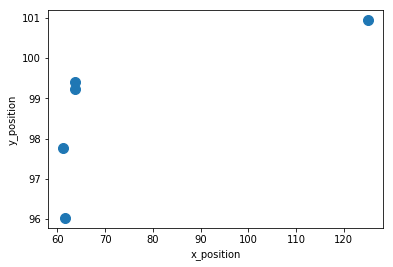

In [15]:
import matplotlib.pyplot as plt
plt.plot(
    ripple_info.x_position,
    ripple_info.y_position,
    linestyle='None', marker='.', markersize=20);
plt.xlabel('x_position')
plt.ylabel('y_position')

In [132]:
def _get_ripple_motion_from_rows(ripple_info, posterior_density, state_names, place_bin_centers):
    '''
    
    Parameters
    ----------
    ripple_info : pandas dataframe row
    posterior_density : array, shape (n_time, n_position_bins)
    state_names : list of str, shape (n_states,)
    place_bin_centers : array (n_position_bins)
    
    Returns
    -------
    is_away : bool

    '''
    joined_state_name = '_'.join((ripple_info.ripple_trajectory, ripple_info.ripple_direction))
    new_shape = (len(posterior_density), len(state_names), -1)
    reshaped_density = np.reshape(
        posterior_density, new_shape)[:, state_names.index(joined_state_name), :]
    replay_position = place_bin_centers[np.argmax(reshaped_density[[0, -1]], axis=1)]
    distance_from_position = abs(ripple_info.linear_position - replay_position)
    return np.diff(distance_from_position) > 0

In [131]:
def _get_ripple_motion(ripple_info, posterior_density, state_names, place_bin_centers):
    return np.array(
        [_get_ripple_motion_from_rows(row, density, state_names, place_bin_centers)
         for (_, row), density
         in zip(ripple_info.iterrows(), posterior_density)]).squeeze()

array([ True,  True,  True, False,  True], dtype=bool)

In [151]:
ripple_info = decode_ripple_clusterless(epoch_key, ANIMALS, ripple_times[:5])[0]
ripple_info

ripple_trajectory ripple_direction  \
animal day epoch ripple_number                                      
HPa    6   2     1                      outbound          reverse   
                 2                      outbound          reverse   
                 3                      outbound          reverse   
                 4                       inbound          reverse   
                 5                      outbound          reverse   

                                ripple_state_probability  ripple_start_time  \
animal day epoch ripple_number                                                
HPa    6   2     1                              0.873182        4137.813333   
                 2                              0.992965        4139.667333   
                 3                              0.988171        4142.945333   
                 4                              0.414060        4168.426667   
                 5                              0.809156        4197.592667   

                                ripple_end_time  \
animal day epoch ripple_number                    
HPa    6   2     1                  4137.874667   
                 2                  4139.732667   
                 3                  4142.986667   
                 4                  4168.463333   
                 5                  4197.628000   

                                number_of_unique_neurons_spiking  \
animal day epoch ripple_number                                     
HPa    6   2     1                                            11   
                 2                                             9   
                 3                                             9   
                 4                                             6   
                 5                                             8   

                                number_of_spikes session_time is_spike  \
animal day epoch ripple_number                                           
HPa    6   2     1                            46        early  isSpike   
                 2                            39        early  isSpike   
                 3                            46        early  isSpike   
                 4                            15        early  isSpike   
                 5                            30        early  isSpike   

                               trajectory_direction trajectory_turn  \
animal day epoch ripple_number                                        
HPa    6   2     1                         Outbound            Left   
                 2                         Outbound            Left   
                 3                         Outbound            Left   
                 4                         Outbound            Left   
                 5                         Outbound            Left   

                                trial_number  linear_distance  x_position  \
animal day epoch ripple_number                                              
HPa    6   2     1                       8.0       186.983089   63.680232   
                 2                       8.0       186.884549   63.759031   
                 3                       8.0       183.265667   61.563055   
                 4                      29.0       184.460973  125.013324   
                 5                      38.0       185.130526   61.239997   

                                y_position  head_direction     speed  \
animal day epoch ripple_number                                         
HPa    6   2     1               99.412275        0.404806  0.000000   
                 2               99.231902       -0.100622  0.110327   
                 3               96.030375       -0.505139  3.035594   
                 4              100.932914        1.314661  1.996566   
                 5               97.757959       -0.079975  2.491374   

                                linear_position ripple_motion  
animal day epoch ripple_number  